## Importing


In [1]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

2.8.0


c:\Users\niloy\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data. We only need good data and anything NOT good is an outlier. 

In [14]:
image_directory = 'carpet/train/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)

train = dataset[0:200]
test = dataset[200:279]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

## Let us also load bad images to verify our trained model. 

In [15]:
bad_images = os.listdir(image_directory + 'bad')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.

## Defining the encoder - decoder network for input to the OutlierVAE detector class. 
# Any encoder and decoder can be used. 

In [4]:
encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

# Defining Encoder

In [6]:
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())
#print(encoder_net.input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None


# Defining the Decoder. 
Start with the bottleneck dimension (encoder vector) and connect to dense layer 
with dim = total nodes in the last conv. in the encoder.

In [7]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())
#print(decoder_net.input_shape)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        3075      
 ranspose)                                                       
                                                      

# Define and train the outlier detector. 

In [12]:
latent_dim = 1024  #(Same as encoding dim. )

# initializing outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.015


#train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

In [10]:
adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=120,
       batch_size=4,
       verbose=True)
#Check the threshold value. Should be the same as defined before. 
print("Current threshold value is: ", od.threshold)

50/50 [=] - 34s 671ms/step - loss_ma: -24640.7539
Current threshold value is:  0.015


In [11]:

#infer_threshold Updates threshold by a value inferred from the percentage of 
#instances considered to be outliers in a sample of the dataset.
#percentage of X considered to be normal based on the outlier score.
#Here, we set it to 99%
od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)

Current threshold value is:  0.004286607429385185


# Saving the trained outlier detector
 # Testing The model on a bad image

The instance score is: 0.003332763
Is this image an outlier (0 for NO and 1 for YES)? 1
Current threshld value is:  0.002


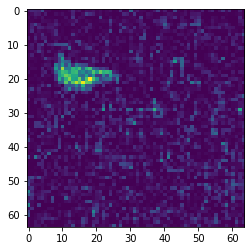

In [16]:
img_num = 9
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

#You can also manually define the threshold based on your specific use case. 
od.threshold = 0.002
print("Current threshld value is: ", od.threshold)

# Let us check it for multiple images

['instance_score', 'feature_score', 'is_outlier']


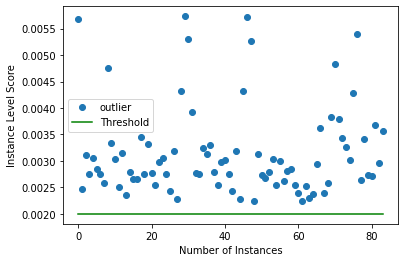

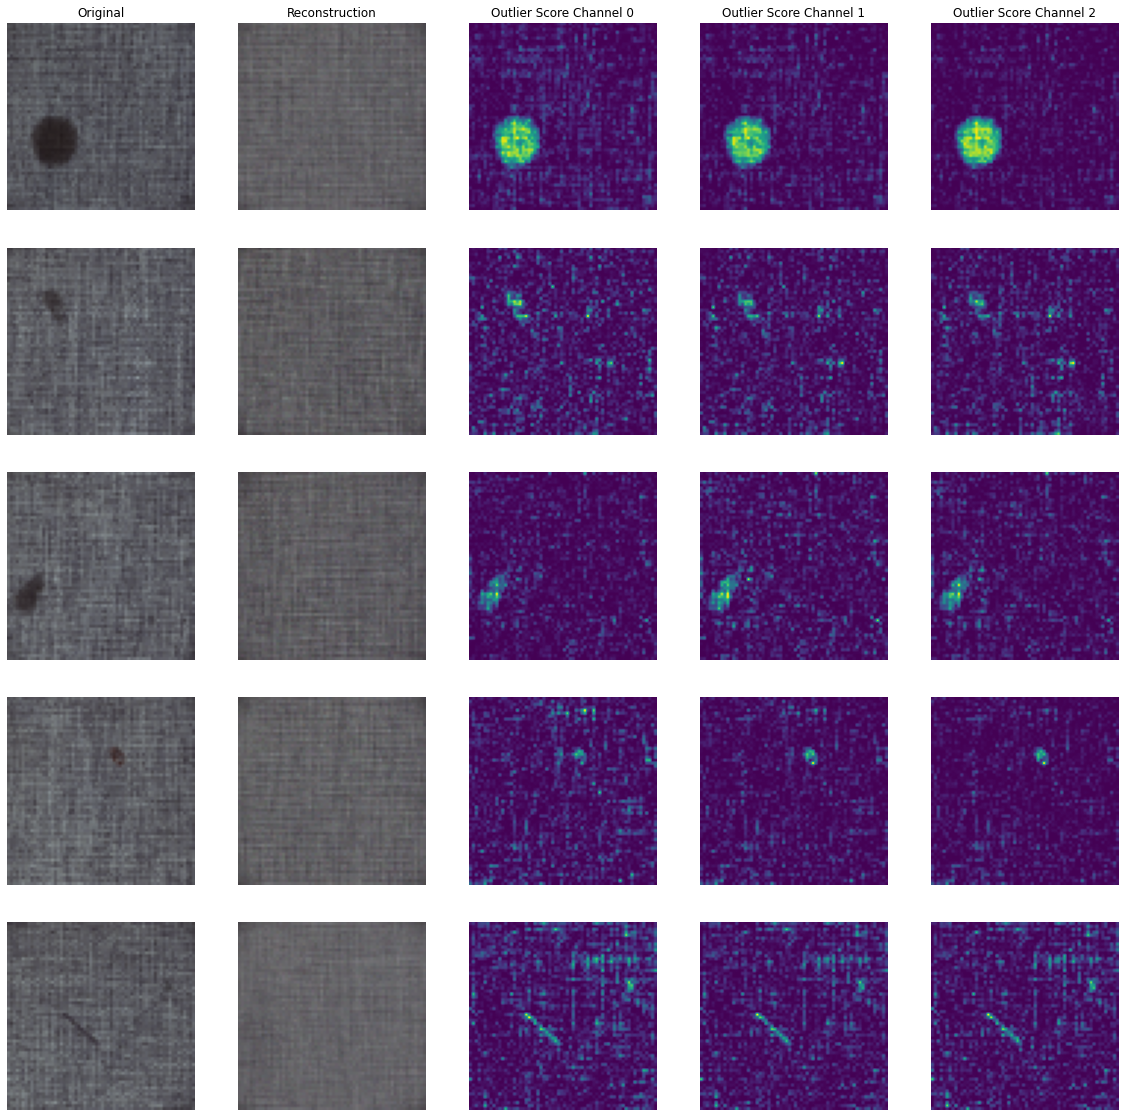

In [17]:
X = bad_dataset[:120]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[0, 5, 10, 15, 17],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions
